In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Latex font
import matplotlib as mpl
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=16)

In [2]:
ms = 1.12                   # stellar mass of 51 Peg (M sun)
ms_error = 0.06             # error in stellar mass (M sun)
fname = "51Pegb.txt"        #open data file and read
data = np.genfromtxt(fname,skip_header=21,autostrip=True)
jd = data[:,0]              # Julian date (day)
rv = data[:,1]              # radial velocity (m/s)
er = data[:,2]              # error in radial velocity (m/s)

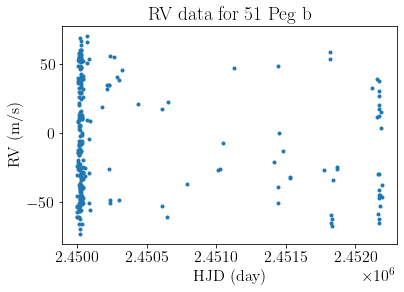

In [3]:
plt.plot(jd,rv,'.')
plt.title('RV data for 51 Peg b')
plt.xlabel('HJD (day)')
plt.ylabel('RV (m/s)')
plt.show()

In [4]:
#compute Lomb-Scargle periodogram from data
from scipy import signal
from astropy.time import Time
from astropy.timeseries import LombScargle
frequency,power = LombScargle(jd,rv,er).autopower()

In [5]:
# find period of strongest signal
period = 1/frequency[np.argmax(power)]
print("The fit period is %10.5f days" % period)

The fit period is    4.23107 days


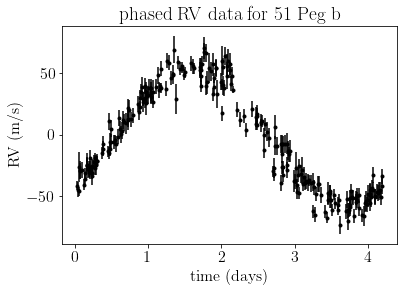

In [6]:
# phase the data and plot it with the fit
phase = jd % period
fig,ax = plt.subplots()
ax.errorbar(phase,rv,er,fmt='.k')
plt.title('phased RV data for 51 Peg b')
plt.xlabel('time (days)')
plt.ylabel('RV (m/s)')
plt.show()

In [7]:
#guesses for the orbital parameters 
vr0 = -2.65528     #m/s
K = 55.60534        #m/s
P = 4.23107         #days
e = 0               #No-unit
w = 0           #No-unit
tau = 2450068.67    #days

In [8]:
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

In [9]:
def keplerian_fit(t,K,P,e,w,tau,vr0):
        e_anomaly = solve_kepler((t-tau)*2*np.pi/P,e)
        theta = 2*np.arctan2(np.sqrt(1.+e)*np.sin(0.5*e_anomaly),
                             np.sqrt(1.-e)*np.cos(0.5*e_anomaly))
        return K*(np.cos(theta+w)+e*np.cos(w))+vr0

In [10]:
def solve_kepler(M,e):
    eanom = np.zeros(M.shape)
    for i,mi in enumerate(M):
        # do iterative root solve with e=0 giving E=M as guess
        tmp,=fsolve(lambda E: E-e*np.sin(E)-mi,mi)
        eanom[i] = tmp
    return eanom

In [11]:
import scipy.optimize as optimization  
guess = (K,P,e,w,tau,vr0)
params, params_covariance = optimization.curve_fit(keplerian_fit, jd, rv,sigma=er, absolute_sigma=True,p0=guess)

K = params[0]
P = params[1]
e = params[2]
w = params[3]
tau = params[4]
vr0 = params[5]


dK = params_covariance[0,0]
dP = params_covariance[1,1]
de = params_covariance[2,2]
dw = params_covariance[3,3]
dtau = params_covariance[4,4]
dvr0 = params_covariance[5,5]

rvfit = keplerian_fit(jd,K,P,e,w,tau,vr0)

if e<0:
    w -= np.pi
    e *= -1
    w_deg = w*180/np.pi
print(K,P,e,w,w_deg,tau,vr0)


print("The parameters of egress part")
print("K =", K, "+/-", dK**0.5)
print("P =", P, "+/-", dP**0.5)
print("e =", e, "+/-", de**0.5)
print("w =", w, "+/-", dw**0.5)
print("w_deg =", w*(180/np.pi), "+/-", dw**0.5*(180/np.pi))
print("tau =", tau, "+/-", dtau**0.5)
print("vr0 =", vr0, "+/-", dvr0**0.5)

55.89441347026184 4.230730573660922 0.012529075233743078 0.9798516850656949 56.14136610304624 2450071.292262271 -1.90495809406362
The parameters of egress part
K = 55.89441347026184 +/- 1.2716319241829976
P = 4.230730573660922 +/- 3.67819161887776e-05
e = 0.012529075233743078 +/- 0.009790799462504215
w = 0.9798516850656949 +/- 0.7493134003128645
w_deg = 56.14136610304623 +/- 42.932495370523874
tau = 2450071.292262271 +/- 0.5055233043783012
vr0 = -1.90495809406362 +/- 0.37786555873150696


In [12]:
P_yr = P/365.2422               # period in years
a_au = (ms*P_yr**2)**(1./3)     # semi-major axis in au
K_auyr = K*2.1096256684e-4      # K in au/yr

# compute planet mass and convert to Jupiter-mass units
mp = (2*np.pi)**(-1)*K_auyr*np.sqrt(1-e**2)*(ms**2*P_yr)**(1/3)
mp_mjup = mp*1047.59421

a_error = np.sqrt( (2*dP/(3*P))**2 + (ms_error/(3*ms))**2 )*a_au

print(a_error)
mp_error = mp_mjup * np.sqrt( (2*ms_error/(3*ms))**2 + (dK/K)**2 + (dP/(3*P))**2 + (e*de/np.sqrt(1-e*e))**2 )

0.0009493818538160247


In [13]:
x = jd%period
x_min, x_max = np.amin(x), np.amax(x)
x_line = np.linspace(x_min, x_max, len(x))
#y_line = sin_fit(x_line, *params)
y_line = keplerian_fit(x_line, *params) #### For all interporation 

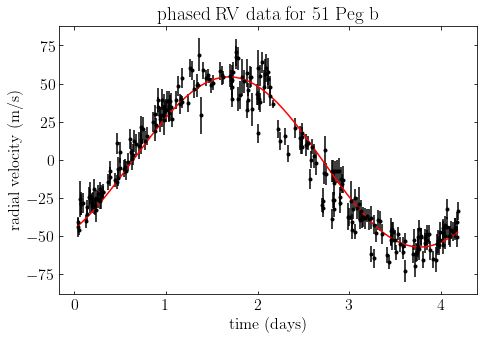

In [14]:
# phase the data and plot it with the fit
phase = jd % period
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(7, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
plt.errorbar(phase,rv,er,fmt='.k')
plt.plot(x_line,y_line,'-r')
plt.title('phased RV data for 51 Peg b')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.show()

In [35]:
print("The Keplerian parameters:")
print("K =", K, "+/-", dK**0.5, 'm/s')
print("P =", P, "+/-", dP**0.5, 'days')
print("e =", e, "+/-", de**0.5)
print("w =", w, "+/-", dw**0.5, 'rad')
print("w_deg =", w*(180/np.pi), "+/-", dw**0.5*(180/np.pi), 'deg')
print("tau =", tau, "+/-", dtau**0.5, 'day')
print("vr0 =", vr0, "+/-", dvr0**0.5, 'm/s')
print ('a=', a_au ,'+/-', a_error, 'AU')
print ('Mpsin(i)=', mp_mjup ,'+/-', mp_error, 'MJ')

The Keplerian parameters:
K = 55.89441347026184 +/- 1.2716319241829976 m/s
P = 4.230730573660922 +/- 3.67819161887776e-05 days
e = 0.012529075233743078 +/- 0.009790799462504215
w = 0.9798516850656949 +/- 0.7493134003128645 rad
w_deg = 56.14136610304623 +/- 42.932495370523874 deg
tau = 2450071.292262271 +/- 0.5055233043783012 day
vr0 = -1.90495809406362 +/- 0.37786555873150696 m/s
a= 0.05316538381369738 +/- 0.0009493818538160247 AU
Mpsin(i)= 0.4797074060332221 +/- 0.02204816994169762 MJ
